# Local Group Halo Properties: Demo Inference

We approximate the local group distance, radial velocity and proper motion likelihood function by sampling from the posterior distributions for these variables reported in the literature and transforming to kinematic variables in the M31-centric coordinate system.

In [1]:
%matplotlib inline
import localgroup
import triangle
import sklearn
from sklearn import mixture
import numpy as np
import pickle
import matplotlib.patches as mpatches

Inside the Likelihood object is a "triplet" object called T, which contains an array of sample local groups, each with kinematic parameters consistent with the observational data. Let's plot these kinematic parameters in a "triangle" figure, to show all their 1 and 2-D marginal distributions.

In [2]:
L = localgroup.Likelihood(isPair=True)
L.generate(Nsamples=200000)

Inside method: heliocentric_equatorial_spherical_to_galactocentric_cartesian
l =  [ 121.22164425  121.33737927  121.19050478 ...,  121.08784447  121.16382073
  121.23382923]
b =  [-21.49267237 -21.66110601 -21.4119188  ..., -21.57855673 -21.48250132
 -21.5893131 ]
mu_l = 122.486339 +/- 30.816436
mu_b = -78.372668 +/- 28.454575
v_west:  -122.486339 +/- 30.816436
v_north: -78.372668 +/- 28.454575


/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/LocalGroupHaloProps/localgroup/halo.py:134: RuntimeWarning: invalid value encountered in divide
  self.v_r = (self.x*self.vx + self.y*self.vy + self.z*self.vz)/self.D


In [3]:
L.set_PDF(mixture.GMM(n_components=10, covariance_type='full'))
L.approximate()

Quantiles:
[(0.16, 0.73427883208492106), (0.5, 0.7738229936628187), (0.84, 0.81370980024714334)]
Quantiles:
[(0.16, -113.66569508651135), (0.5, -109.23662379222537), (0.84, -104.80416299381416)]
Quantiles:
[(0.16, 18.917001901609254), (0.5, 37.717930309726725), (0.84, 61.467660922396369)]


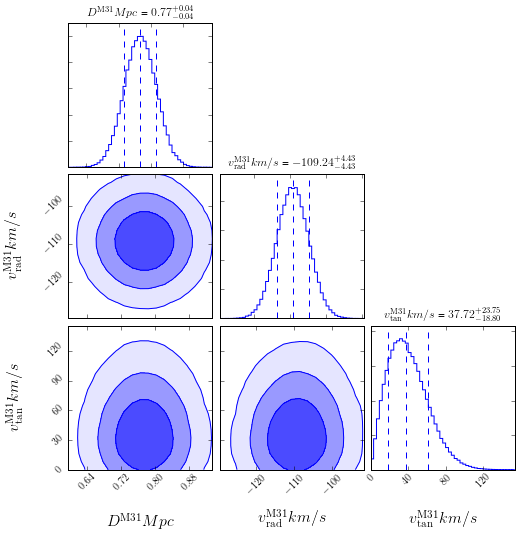

In [4]:
figure_obs = L.plot_samples(10, color='b', overlay=False)

The above plot shows a Gaussian Mixture model fitted Gaussians. The shaded regions show two standard deviations. The samples data has been preprocessed to zero the mean and scale by standard deviation. Since we are using the Gaussian Mixture Model to model the underlying PDF of the data, more components is always better. 

# How to evaluate goodness of fit:

Due to lack of a standard goodness of fit test for GMM's, the best we can do is graphically show that the model reproduces the data well. We proceed by drawing a set of points from the fitted model, where each point is a local group with (MW_D, MW_vr, MW_vt, M33_D, M33_vr, M33_vt). We then plot the 1D and 2D marginalizations of the drawn point set and show that the marginalizations match the marginalizations of the true data.

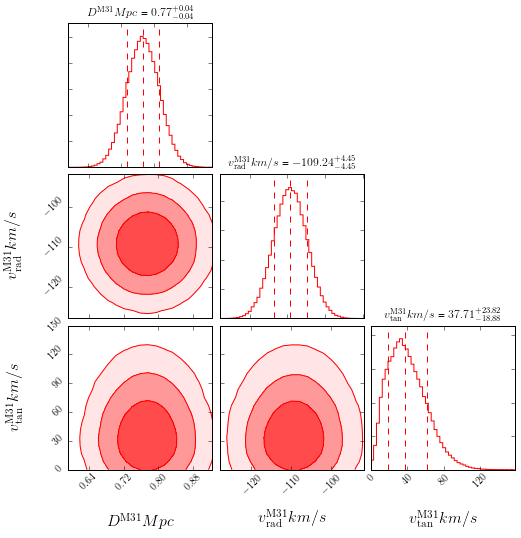

In [5]:
figure_model = L.model_gof(L.T.Nsamples, color="r", fig=None)

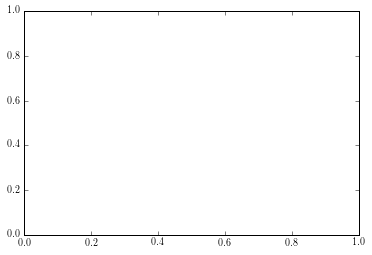

In [6]:
L.model_gof(L.T.Nsamples, color="r", fig=figure_obs)
red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')
figure_obs.legend(handles=[red_patch, blue_patch], labels=["Model Generated", "Observation Generated"])

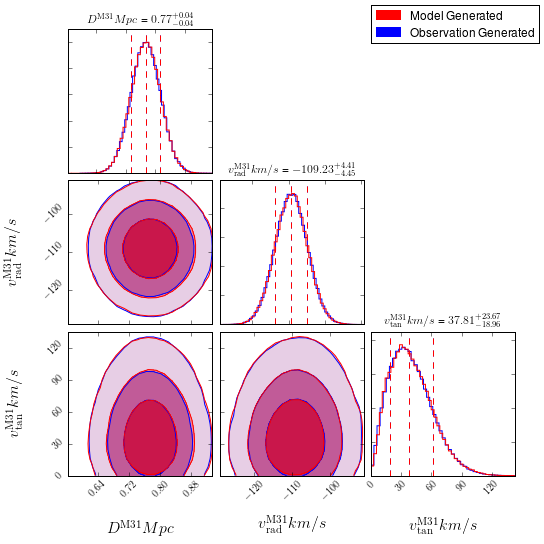

In [7]:
figure_obs

The above plot shows that the points drawn from the model create a population that is very similar to the true data.

In [8]:
#figure_obs.savefig("/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/LocalGroupHaloProps/doc/thesis/plots/model_gof.png")

# Reading Simulation Points:

Below we read the preconfigured files containing the Consuelo (soon to be Dark Sky) Local Group analogs into a Triplet object. We plot the marginalizations of the simulation data, which allows us to compare with the LG prior.

In [9]:
path = '/lustre/ki/pfs/mwillia1/LG_project/Consuelo_Boxes/All_Boxes/Pairs/All_Boxes_dat_M31_larger.npy'
npoints = 100000
halo_props = ['MW_Mvir', 'M31_Mvir', 'M33_Mvir']

In [40]:
Tr = localgroup.Triplet(isPair=True)
Tr.read_sim_points(path, npoints, halo_props, h=0.7, a=1.0, npy=True)

In [41]:
Tr.transform_to_M31(sim=True)

In [42]:
#Tr.mass_filter('sim')

sim_sample length before:  (100000, 3)
sim_sample length after:  (99699, 3)


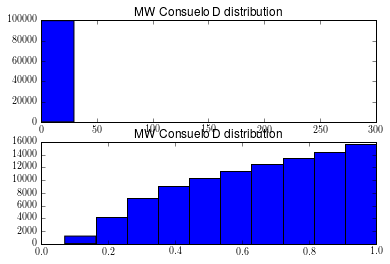

In [43]:
Tr.dist_filter((Tr.sim_samples[:,0] < 10))

In [44]:
Tr.preprocess(L.samples_means, L.samples_stds, mode='sim')

Quantiles:
[(0.16, 0.3858123204932451), (0.5, 0.67628750687412587), (0.84, 0.90541031853755216)]
Quantiles:
[(0.16, -105.4853577083428), (0.5, -26.41202383739288), (0.84, 8.6289242285905736)]
Quantiles:
[(0.16, 11.302623536398224), (0.5, 29.99830136388281), (0.84, 85.078767302451311)]
Quantiles:
[(0.16, 10.580137745047978), (0.5, 11.104452967322292), (0.84, 11.773852242190911)]
Quantiles:
[(0.16, 10.833746165250007), (0.5, 11.429542347179433), (0.84, 12.195539896549318)]


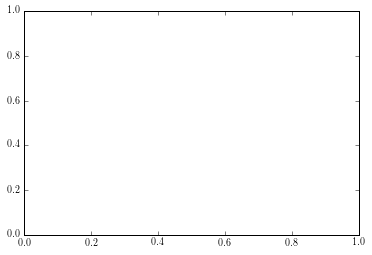

In [48]:
Tr.unprocess(L.samples_means, L.samples_stds, mode='sim')
data = np.transpose(np.vstack((np.transpose(Tr.sim_samples), np.log10(Tr.MW.Mvir), np.log10(Tr.M31.Mvir))))
labs=["MWd", "MWvr", "MWvt", "MWMvir", "M31Mvir"]
sim_plot = triangle.corner(data, labels=labs, quantiles=[0.16,0.5,0.84], fig=pl, weights=None,\
                         plot_contours=True, show_titles=True, title_args={"fontsize": 16}, \
                         plot_datapoints=False, bins=20, color='r', label_args={"fontsize": 16})
red_patch = mpatches.Patch(color='r')
cyan_patch = mpatches.Patch(color='c')
sim_plot.legend(handles=[red_patch, cyan_patch], labels=["CONSUELO Prior", "GMM Prior Approximation"])
Tr.preprocess(L.samples_means, L.samples_stds, mode='sim')

In [49]:
#name = 'gmm_CONSUELO_prior.png'
#sim_plot.savefig('/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/LocalGroupHaloProps/doc/thesis/plots/asurps/'+name)

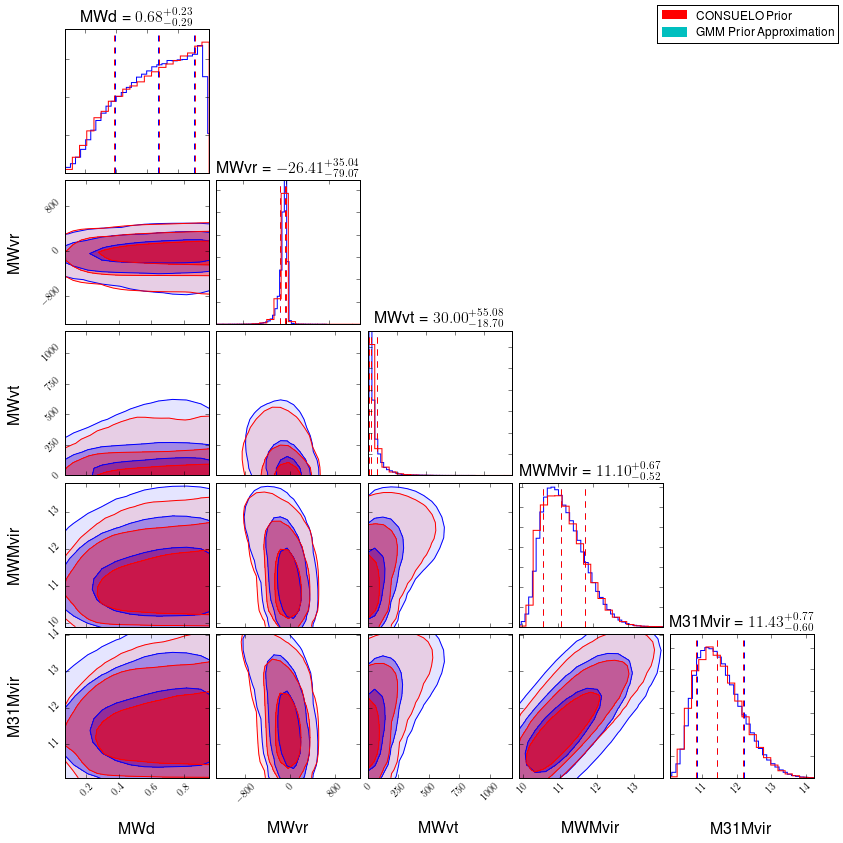

In [50]:
pl

In [30]:
Tr.unprocess(L.samples_means, L.samples_stds, 'gmm')
print np.mean(Tr.sim_samples[:,0])
Tr.preprocess(L.samples_means, L.samples_stds, mode='gmm')

-3.12647754206


In [27]:
def num_bins(std, rg, N):
    return rg/(3.5*std/N**(1.0/3.0))

In [ ]:
num_bins(5.7)

In [45]:
dat = np.transpose(np.vstack((np.transpose(Tr.sim_samples), np.log10(Tr.M31.Mvir), np.log10(Tr.MW.Mvir))))
Tr.GMM(20, dat)

In [46]:
Tr.GMM_sample(500000, L, reps=1, simple=True)

gmm_MW = np.copy(Tr.gmm_samples[:,4])
gmm_M31 = np.copy(Tr.gmm_samples[:,3])
gmm_LG = np.log10(np.power(10,gmm_MW) + np.power(10,gmm_M31))

#cond = gmm_MW < gmm_M31
#Tr.gmm_samples = Tr.gmm_samples[cond]
#gmm_MW = gmm_MW[cond]
#gmm_M31 = gmm_M31[cond]
#gmm_LG = gmm_LG[cond]

Tr.gmm_samples = Tr.gmm_samples[:,0:3]

In [23]:
Tr.compute_model_weights(L, 'gmm')

In [24]:
Tr.calculate_N95()

(611, 0.00023385027591306138)

Quantiles:
[(0.16, 0.39226638595528929), (0.5, 0.67294583291658938), (0.84, 0.90247812105726077)]
Quantiles:
[(0.16, -106.38251806467058), (0.5, -26.740081861953641), (0.84, 9.0106757952700764)]
Quantiles:
[(0.16, 11.55651284060713), (0.5, 30.37326381385266), (0.84, 85.454481229908495)]
Quantiles:
[(0.16, 10.596498082624944), (0.5, 11.097675031887135), (0.84, 11.772504442291027)]
Quantiles:
[(0.16, 10.846816265887451), (0.5, 11.428243109524509), (0.84, 12.197333921340032)]


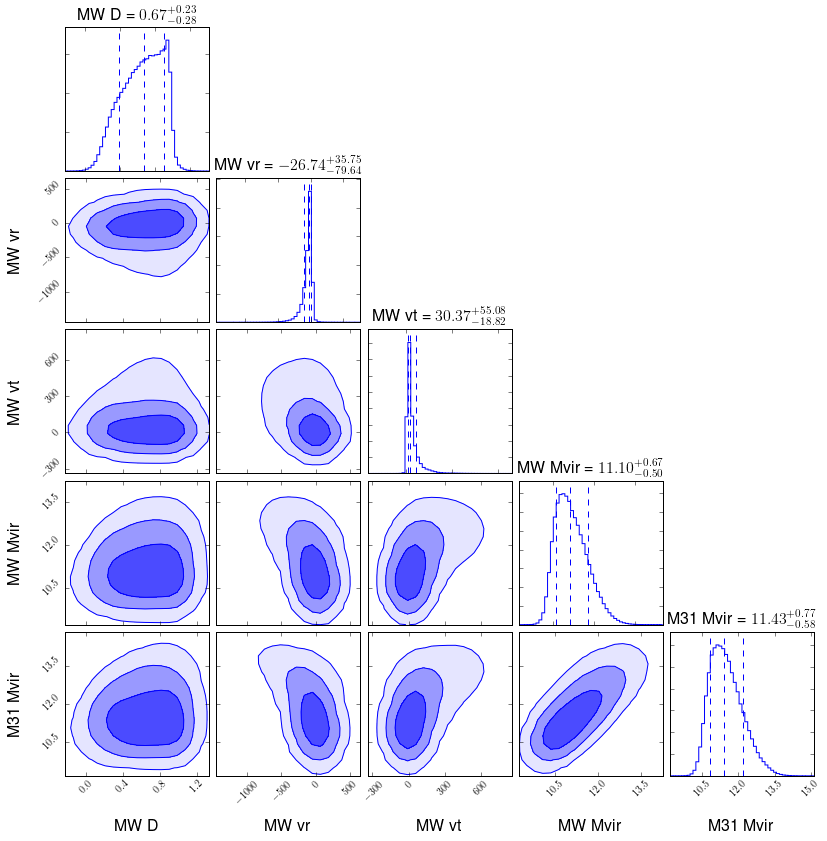

In [51]:
Tr.unprocess(L.samples_means, L.samples_stds, 'gmm')
data2 = np.transpose(np.vstack((np.transpose(Tr.gmm_samples), gmm_MW, gmm_M31)))
labs=["MW D", "MW vr", "MW vt", "MW Mvir", "M31 Mvir"]
pl = triangle.corner(data2, labels=labs, quantiles=[0.16,0.5,0.84], fig=None, weights=None,\
                         plot_contours=True, show_titles=True, title_args={"fontsize": 16}, label_args={"fontsize": 16},\
                         plot_datapoints=False, bins=50, color='b')
Tr.preprocess(L.samples_means, L.samples_stds, mode='gmm')

Quantiles:
[(0.16, 0.3858123204932451), (0.5, 0.67628750687412587), (0.84, 0.90541031853755216)]
Quantiles:
[(0.16, -105.4853577083428), (0.5, -26.41202383739288), (0.84, 8.6289242285905736)]
Quantiles:
[(0.16, 11.302623536398224), (0.5, 29.99830136388281), (0.84, 85.078767302451311)]
Quantiles:
[(0.16, 10.580137745047978), (0.5, 11.104452967322292), (0.84, 11.773852242190911)]
Quantiles:
[(0.16, 10.833746165250007), (0.5, 11.429542347179433), (0.84, 12.195539896549318)]


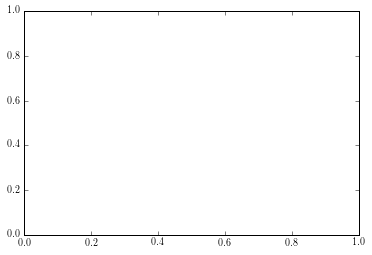

In [52]:
Tr.unprocess(L.samples_means, L.samples_stds, mode='sim')
data = np.transpose(np.vstack((np.transpose(Tr.sim_samples), np.log10(Tr.MW.Mvir), np.log10(Tr.M31.Mvir))))
labs=["MW D", "MW vr", "MW vt", "MW Mvir", "M31 Mvir"]
sim_plot = triangle.corner(data, labels=labs, quantiles=[0.16,0.5,0.84], fig=pl, weights=None,\
                         plot_contours=True, show_titles=False, title_args={"fontsize": 12}, \
                         plot_datapoints=False, bins=50, color='r', label_kwargs={"fontsize": 16}, label_args={"fontsize": 16})
red_patch = mpatches.Patch(color='r')
cyan_patch = mpatches.Patch(color='b')
sim_plot.legend(handles=[red_patch, cyan_patch], labels=["CONSUELO Prior", "GMM-fit CONSUELO Prior"], fontsize=16)
sim_plot.suptitle("GMM Prior Overlayed with Consuelo Prior", fontsize=16)
Tr.preprocess(L.samples_means, L.samples_stds, mode='sim')w

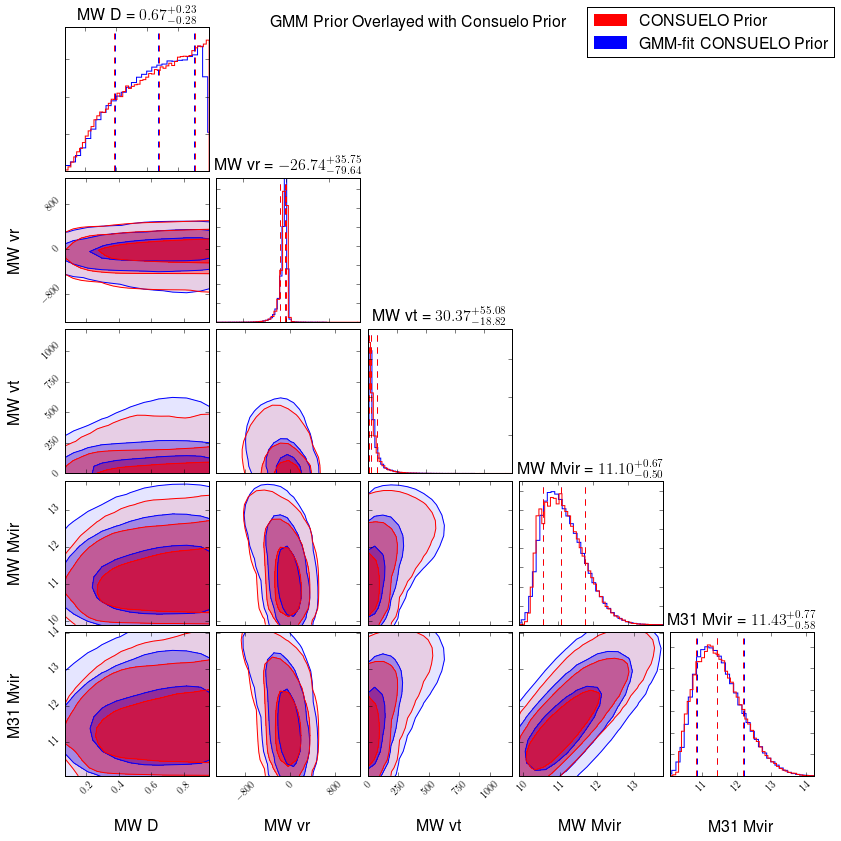

In [53]:
sim_plot

In [40]:
sim_plot.savefig('/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/LocalGroupHaloProps/doc/thesis/plots/final_plots/PGMM_vs_P.png', dpi=1200)

Quantiles:
[(0.16, 11.365546056477994), (0.5, 11.72877887235899), (0.84, 12.06940596650759)]
Quantiles:
[(0.16, 11.785186557343202), (0.5, 12.204424481393714), (0.84, 12.490230682018254)]
Quantiles:
[(0.16, 11.983325612445864), (0.5, 12.354636469872387), (0.84, 12.617354154065424)]


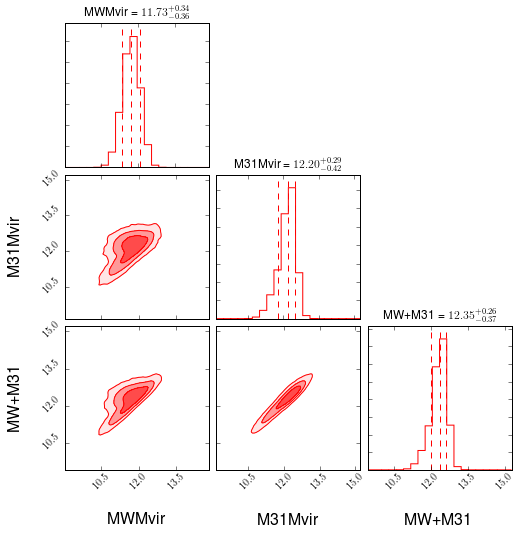

In [14]:
labs = ["MWMvir", "M31Mvir", "MW+M31"]
all_mvir = np.transpose(np.vstack((gmm_MW, gmm_M31, gmm_LG)))
figure = triangle.corner(all_mvir, labels=labs, quantiles=[0.16,0.5,0.84], fig=None, weights=Tr.weights,\
                         plot_contours=True, show_titles=True, label_args={"fontsize": 16}, title_args={"fontsize": 12}, \
                         plot_datapoints=False, bins=20, color='red')